<a href="https://colab.research.google.com/github/MShloka/ml-mini-project/blob/main/ML_mini_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fugashi[unidic-lite] scikit-learn pandas joblib gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 28.6 MB/s eta 0:00:00
  Created wheel for unidic-lite: filename=unidic_lite-1.0.8-py3-none-any.whl size=47658817 sha256=bb5a1f326ae6a0872d60ca857bf76f6527a4c01f4114fa07182084914408f430
  Stored in directory: /root/.cache/pip/wheels/5e/1f/0f/4d43887e5476d956fae828ee9b6687becd5544d68b51ed633d
Successfully built unidic-lite


In [3]:
import os
os.makedirs("data", exist_ok=True)
os.makedirs("models", exist_ok=True)

✅ All libraries imported successfully!
Dataset shape: (50, 2)
            text level
0        私は学生です。    N5
1      これはペンですか。    N5
2    昨日は映画を見ました。    N5
3  猫がテーブルの上にいます。    N5
4   日本語を勉強しています。    N5
✅ Filtered Levels:
level
N5    10
N4    10
N3    10
N2    10
N1     9
Name: count, dtype: int64

📊 Classification Report:
              precision    recall  f1-score   support

          N1       1.00      0.50      0.67         2
          N2       0.33      0.50      0.40         2
          N3       0.00      0.00      0.00         2
          N4       0.00      0.00      0.00         2
          N5       0.33      0.50      0.40         2

    accuracy                           0.30        10
   macro avg       0.33      0.30      0.29        10
weighted avg       0.33      0.30      0.29        10



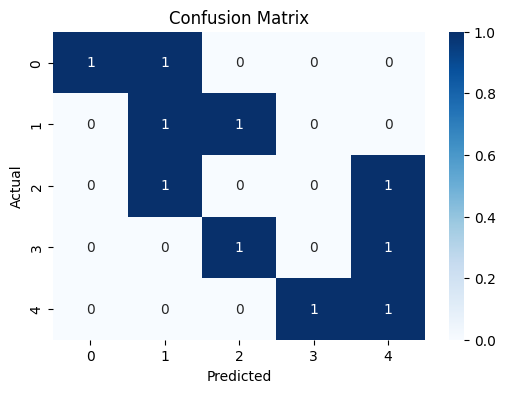

✅ Model and vectorizer saved successfully!
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1a72f484d62159fbed.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [6]:
import pandas as pd
import fugashi, gradio, joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All libraries imported successfully!")

# STEP 2: Load Dataset
df = pd.read_csv("/content/data/japanese.csv")  # adjust path if needed
print("Dataset shape:", df.shape)
print(df.head())

# STEP 3: Tokenization using fugashi
tagger = fugashi.Tagger()

def tokenize(text):
    return " ".join([word.surface for word in tagger(text)])

df["processed"] = df["text"].astype(str).apply(tokenize)

# STEP 4: Remove rare levels (with only 1 example)
df = df.groupby("level").filter(lambda x: len(x) > 1)
print("✅ Filtered Levels:")
print(df["level"].value_counts())

# STEP 5: Split Data
X_train, X_test, y_train, y_test = train_test_split(
    df["processed"], df["level"], test_size=0.2, random_state=42, stratify=df["level"]
)

# STEP 6: TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=3000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# STEP 7: Train Naive Bayes Model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# STEP 8: Evaluate
y_pred = model.predict(X_test_vec)
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# STEP 9: Save Model + Vectorizer
joblib.dump(model, "models/japanese_level_model.joblib")
joblib.dump(vectorizer, "models/vectorizer.joblib")
print("✅ Model and vectorizer saved successfully!")

# STEP 10: Gradio Interface
def predict_level(sentence):
    processed = " ".join([word.surface for word in tagger(sentence)])
    vec = vectorizer.transform([processed])
    pred = model.predict(vec)[0]
    return f"Predicted JLPT Level: {pred}"

interface = gradio.Interface(
    fn=predict_level,
    inputs=gradio.Textbox(label="Enter a Japanese sentence"),
    outputs="text",
    title="🗾 Japanese Sentence Level Classifier",
    description="Predicts the JLPT difficulty level (N5–N1) of a given Japanese sentence."
)

interface.launch(share=True)